# Batch effect examination

4/30/2020 Mamie Wang

The goal is to examine the two CD8 samples (blood and tumor) to see whether the difference between samples are mainly biological or technical. We examine the cell subpopulation composition separately for the two samples and find subpopulations that are overlapping or distinct.

In [1]:
library(Seurat)
library(ggplot2)
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.4  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [ ]:
# load preprocessed Seurat object
path = "/data/rq25/liliana_10x_human_TIL_202003/seurat_analysis/integrated_data_S.rds"
data = readRDS(path)

In [22]:
data

An object of class Seurat 
45068 features across 58615 samples within 1 assay 
Active assay: RNA (45068 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [23]:
unique(data@meta.data$orig.ident) # BL: blood, TIL: tumor

[1] "YUTAS_BL_CD8"      "YUTAS_BL_TEFF"     "YUTAS_BL_TREG"    
[4] "YUTAS_TIL_CD8"     "YUTAS_TIL_TEFF"    "YUTAS_TIL_TREG"   
[7] "YUTAS_TIL_exp"     "YUTAS_BL_initial"  "YUTAS_TIL_initial"

## Extract subset of CD8 cells in blood and TIL

In [24]:
is_blood_cd8 = data@meta.data$orig.ident == "YUTAS_BL_CD8"
is_tumor_cd8 = data@meta.data$orig.ident == "YUTAS_TIL_CD8"

In [25]:
cd8 = data[,is_blood_cd8 | is_tumor_cd8]

In [26]:
cd8 <- FindVariableFeatures(cd8, selection.method = "vst", nfeatures = 2000)

In [27]:
head(VariableFeatures(cd8), 10)

[1] "CCL4"     "CCL4L2"   "TRBV4-2"  "XCL1"     "TRBV12-3" "TUBA1B"  
 [7] "XCL2"     "TRBV12-4" "TRBV4-1"  "CXCL13"

In [28]:
# mask the 196 TCR genes from PCA analysis
to_mask <- purrr::map_lgl(rownames(cd8), ~grepl("^TR[AB][VDJ][0-9]", .x))
cd8_masked <- FindVariableFeatures(cd8[!to_mask,], selection.method = "vst", nfeatures = 2000)

In [29]:
# top 10 highly variable genes in all CD8 cells
head(VariableFeatures(cd8_masked), 10)

[1] "CCL4"     "CCL4L2"   "XCL1"     "TUBA1B"   "XCL2"     "CXCL13"  
 [7] "STMN1"    "CCL3"     "HSPA1A"   "HIST1H4C"

In [30]:
cd8_masked <- ScaleData(cd8_masked, features = rownames(cd8_masked), verbose = F)
cd8_masked <- RunPCA(cd8_masked, features = VariableFeatures(object = cd8_masked), verbose = F)

Centering and scaling data matrix


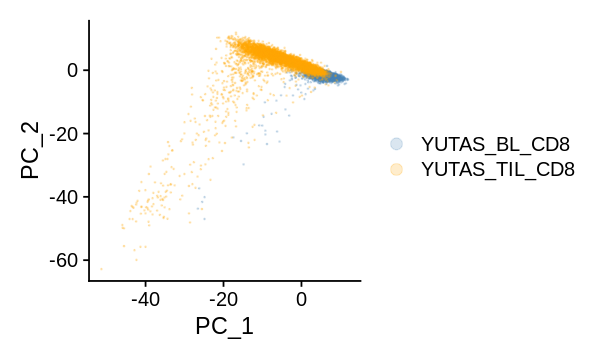

In [31]:
options(repr.plot.width = 5, repr.plot.height = 3)
DimPlot(cd8_masked, reduction = "pca") +
 scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2))

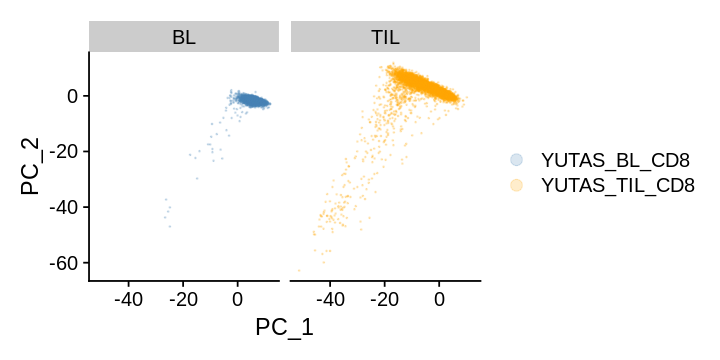

In [32]:
options(repr.plot.width = 6, repr.plot.height = 3)
DimPlot(cd8_masked, reduction = "pca") +
 scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2)) +
 facet_wrap(~ purrr::map_chr(cd8_masked@meta.data$orig.ident, ~strsplit(.x, "_")[[1]][2]))

In [54]:
cd8_masked <- RunUMAP(cd8_masked, dims = 1:10, verbose = F)

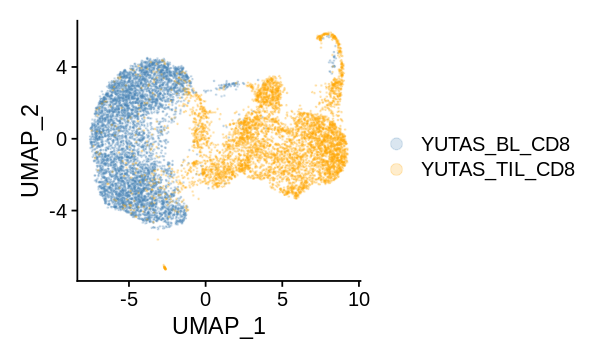

In [57]:
options(repr.plot.width = 5, repr.plot.height = 3)
DimPlot(cd8_masked, reduction = "umap") +
  scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2))

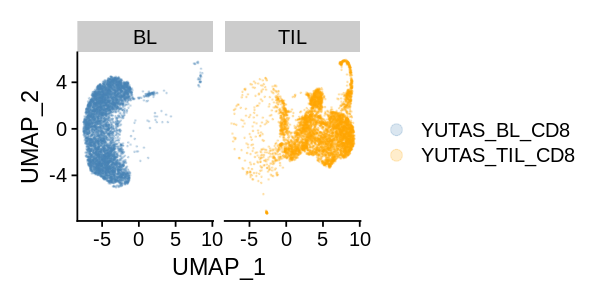

In [59]:
options(repr.plot.width = 5, repr.plot.height = 2.5)
DimPlot(cd8_masked, reduction = "umap") +
  scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2)) + 
 facet_wrap(~ purrr::map_chr(cd8_masked@meta.data$orig.ident, ~strsplit(.x, "_")[[1]][2]))

The embedded data looks different. Not sure if it is batch effect or biological difference between tissues. We will analyze the data separately for now. 

In [33]:
blood_cd8 = cd8_masked[,cd8_masked@meta.data$orig.ident == "YUTAS_BL_CD8"]
tumor_cd8 = cd8_masked[,cd8_masked@meta.data$orig.ident == "YUTAS_TIL_CD8"]

## Blood CD8

In [34]:
blood_cd8

An object of class Seurat 
44872 features across 5649 samples within 1 assay 
Active assay: RNA (44872 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [35]:
blood_cd8 <- FindVariableFeatures(blood_cd8, selection.method = "vst", nfeatures = 2000)
blood_cd8 <- ScaleData(blood_cd8, features = rownames(blood_cd8), verbose = F)
blood_cd8 <- RunPCA(blood_cd8, features = VariableFeatures(object = blood_cd8), verbose = F)

In [36]:
blood_cd8 <- FindNeighbors(blood_cd8, dims = 1:10, verbose = F)

In [37]:
blood_cd8 <- FindClusters(blood_cd8, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5649
Number of edges: 173985

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8738
Number of communities: 5
Elapsed time: 0 seconds


In [ ]:
blood_cd8 <- RunUMAP(blood_cd8, dims = 1:10, verbose = F)

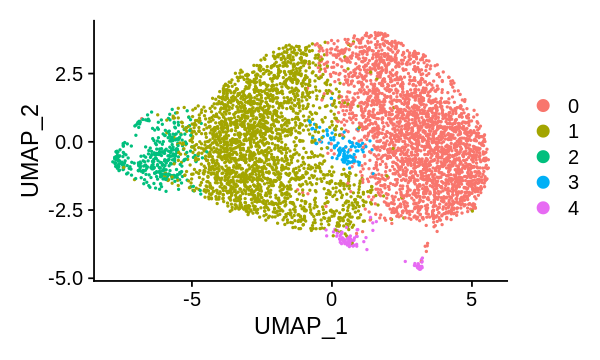

In [39]:
options(repr.plot.width = 5, repr.plot.height = 3)
DimPlot(blood_cd8, reduction = "umap")

In [40]:
blood_cd8_markers <- FindAllMarkers(blood_cd8, only.pos = TRUE, min.pct = 0.25, 
                                    logfc.threshold = 0.25, verbose = F)

Here are top 3 upregulated genes for each marker from differential expression analysis. 

In [41]:
top_3_per_cluster = blood_cd8_markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC)
top_3_per_cluster[,c(6,7,2,3,4)]

cluster,gene,avg_logFC,pct.1,pct.2
0,FGFBP2,1.611700,0.787,0.208
0,GZMH,1.445534,0.934,0.401
0,GZMB,1.314841,0.738,0.224
1,GZMK,1.314571,0.777,0.185
1,IL7R,1.011473,0.637,0.174
1,LTB,0.723521,0.597,0.231
2,SELL,1.268668,0.718,0.125
2,LTB,1.163282,0.903,0.351
2,NOSIP,1.176321,0.820,0.272
3,TYROBP,2.275787,0.636,0.013


In [42]:
plist = FeaturePlot(blood_cd8, features = top_3_per_cluster$gene, combine = F)
p1 <- list() 
for (i in seq_along(plist)){
    p1[[i]] = plist[[i]] + theme(axis.text = element_blank(), 
                                 axis.title = element_blank(),
                                axis.ticks = element_blank(), 
                                legend.position = "none") 
}

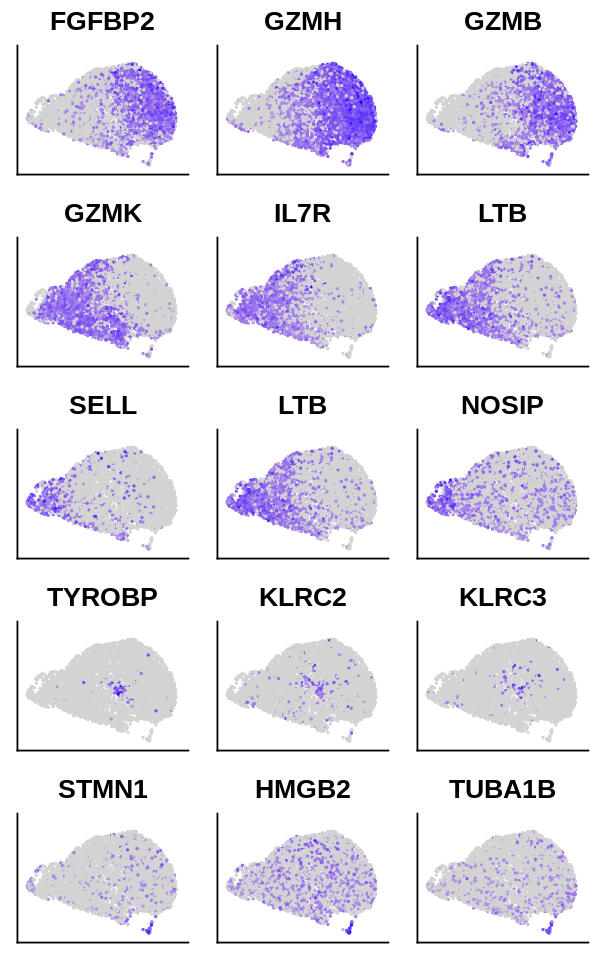

In [43]:
options(repr.plot.width = 5, repr.plot.height = 8)

cowplot::plot_grid(plotlist = p1, ncol = 3) 

The last two clusters look like natural killer cell and cycling cells.

## Tumor CD8

In [44]:
tumor_cd8

An object of class Seurat 
44872 features across 5376 samples within 1 assay 
Active assay: RNA (44872 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [45]:
tumor_cd8 = FindVariableFeatures(tumor_cd8, selection.method = "vst", nfeatures = 2000)
tumor_cd8 <- ScaleData(tumor_cd8, features = rownames(tumor_cd8), verbose = F)
tumor_cd8 <- RunPCA(tumor_cd8, features = VariableFeatures(object = tumor_cd8), verbose = F)

In [46]:
tumor_cd8 <- FindNeighbors(tumor_cd8, dims = 1:10, verbose = F)

In [47]:
tumor_cd8 <- FindClusters(tumor_cd8, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5376
Number of edges: 171642

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8577
Number of communities: 8
Elapsed time: 0 seconds


In [48]:
tumor_cd8 <- RunUMAP(tumor_cd8, dims = 1:10, verbose = F)

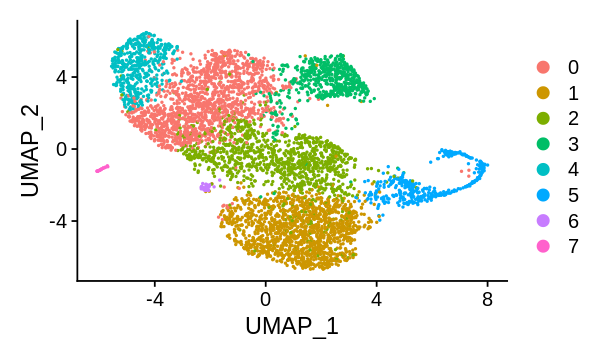

In [49]:
options(repr.plot.width = 5, repr.plot.height = 3)
DimPlot(tumor_cd8, reduction = "umap")

In [50]:
tumor_cd8_markers <- FindAllMarkers(tumor_cd8, only.pos = TRUE, min.pct = 0.25, 
                                    logfc.threshold = 0.25, verbose = F)

Here are top 3 upregulated genes for each marker from differential expression analysis. 

In [51]:
top_3_per_cluster = tumor_cd8_markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC)
top_3_per_cluster[,c(6,7,2,3,4)]

cluster,gene,avg_logFC,pct.1,pct.2
0,IL7R,1.0944987,0.537,0.207
0,GZMK,0.6450328,0.907,0.669
0,LTB,0.6977364,0.628,0.405
1,MIR155HG,1.2622845,0.719,0.230
1,AC133644.2,1.1664130,0.694,0.244
1,CCL3,1.1252095,0.644,0.269
2,XCL1,1.9533114,0.875,0.294
2,XCL2,1.8179289,0.720,0.199
2,CCL4L2,0.8579515,0.376,0.298
3,GNLY,1.5034624,0.925,0.595


In [52]:
plist = FeaturePlot(tumor_cd8, features = top_3_per_cluster$gene, combine = F)
p1 <- list() 
for (i in seq_along(plist)){
    #Change x and y tick label font size.
    p1[[i]] = plist[[i]] + theme(axis.text = element_blank(), 
                                 axis.title = element_blank(),
                                axis.ticks = element_blank(), 
                                legend.position = "none") 
}

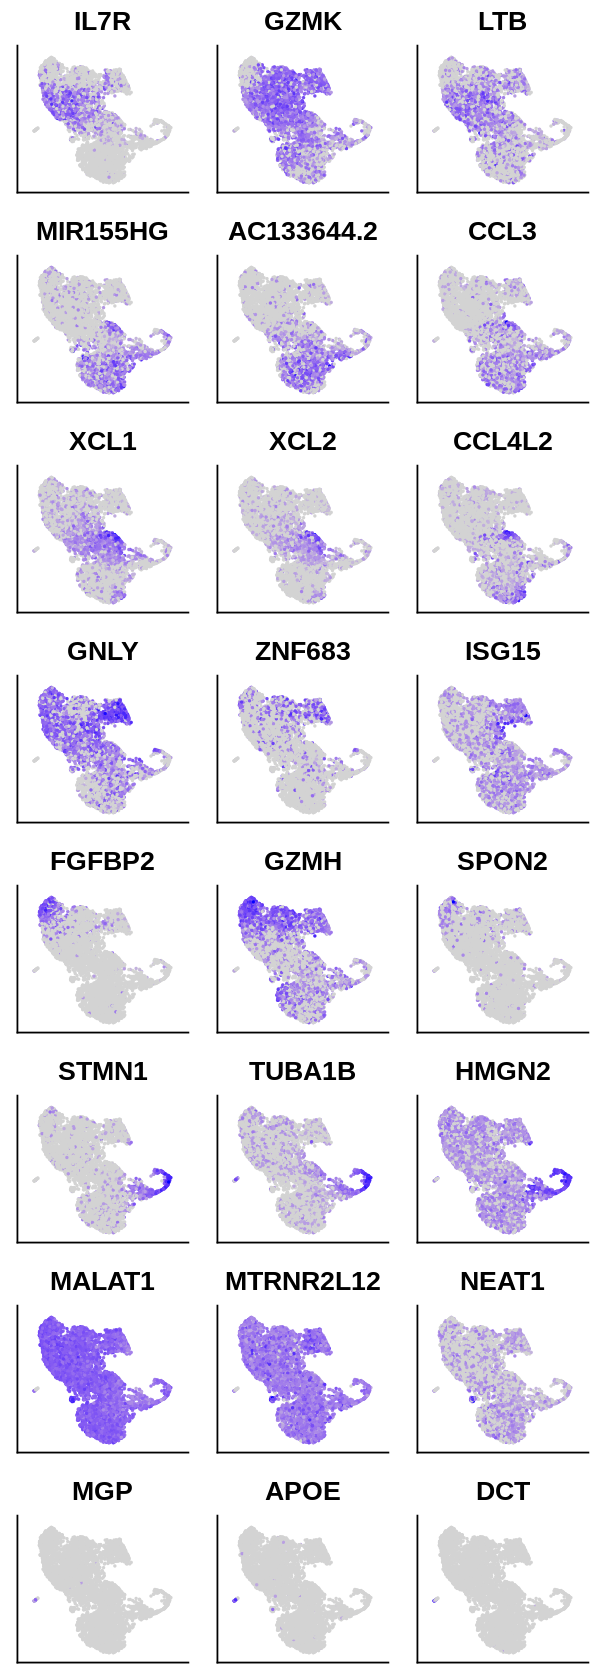

In [53]:
options(repr.plot.width = 5, repr.plot.height = 14)

cowplot::plot_grid(plotlist = p1, ncol = 3) 

The last three clusters looks like cycling cells, cancer cells, vascular smooth muscle cells? It looks like there are two clusters that are really overlapping between blood and tumor samples. May be the batch effect is not that great in the end.

Let's check the marker plot for the IL7R, FGFBP2 on the original combined map. 

In [64]:
plist = FeaturePlot(cd8_masked, features = c("IL7R", "FGFBP2", "STMN1"), combine = F)
p1 <- list() 
for (i in seq_along(plist)){
    #Change x and y tick label font size.
    p1[[i]] = plist[[i]] + theme(axis.text = element_blank(), 
                                 axis.title = element_blank(),
                                axis.ticks = element_blank(), 
                                legend.position = "none") 
}

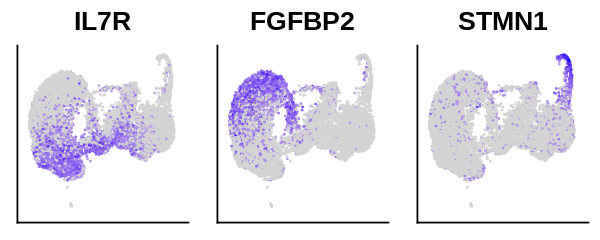

In [66]:
options(repr.plot.width = 5, repr.plot.height = 2)

cowplot::plot_grid(plotlist = p1, ncol = 3) 

Here is the plot from above just as a reference. 

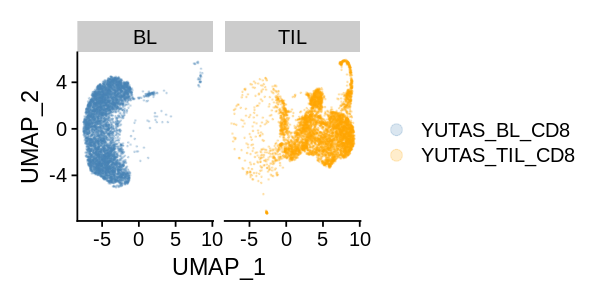

In [59]:
options(repr.plot.width = 5, repr.plot.height = 2.5)
DimPlot(cd8_masked, reduction = "umap") +
  scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2)) + 
 facet_wrap(~ purrr::map_chr(cd8_masked@meta.data$orig.ident, ~strsplit(.x, "_")[[1]][2]))

## Next: trajectory analysis